<a href="https://colab.research.google.com/github/monbrandao/portfolio/blob/main/Trabalho_Machine_Learning_Analise_das_Reviews_de_Cafes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise das Reviews de Cafés

---
### O objetivo desse trabalho pré-processar os dados, e classificar as revisões como positivas ou negativas com base no texto da revisão



In [ ]:
#Retirando as mensagens de warnings - inibir o codigo se precosar ver se tem erros 

import warnings
warnings.filterwarnings('ignore')
#!pip install matplotlib==3.1.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
workdir_path = '/content/drive/My Drive/Colab Notebooks' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

In [ ]:

import pandas as pd

### 1. Carga inicial dos dados

In [ ]:

# ler arquivo csv
data = pd.read_csv('coffee.csv')

# Estrutura dos dados
data.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted to love this. I was even prepared for...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups were excellent. T...
2,AJ3L5J7GN09SV,2,I bought the Grove Square hazelnut cappuccino ...
3,A3CZD34ZTUJME7,1,"I love my Keurig, and I love most of the Keuri..."
4,AWKN396SHAQGP,1,It's a powdered drink. No filter in k-cup.<br ...


In [ ]:
# Quantidade de linhas

print(data.shape[0])

542


In [ ]:
# Verificar se existe algum valor nulo por coluna

print(data.isnull().any())

user_id    False
stars      False
reviews    False
dtype: bool


In [ ]:
# Verificar a quantidade de reviews por estrela

data.stars.value_counts(normalize=True)

5    0.568266
1    0.177122
4    0.119926
2    0.083026
3    0.051661
Name: stars, dtype: float64

In [ ]:
import numpy as np

# Percebendo que os comentários 3 estrelas eram de cunho negativo, achei melhor deixar 3 estrelas na analise ao invéz de remover 

# Defina 4/5 estrelas como positivas, o resto como negativo
data['opinion'] = np.where(data['stars'] >= 4, 'pos', 'neg')

# Incluir apenas as colunas de opinião e comentários
data = data[['opinion', 'reviews']]
data.head()

,opinion,reviews
0,neg,I wanted to love this. I was even prepared for...
1,pos,Grove Square Cappuccino Cups were excellent. T...
2,neg,I bought the Grove Square hazelnut cappuccino ...
3,neg,"I love my Keurig, and I love most of the Keuri..."
4,neg,It's a powdered drink. No filter in k-cup.<br ...


In [ ]:
# Quantidade de avaliações positivas e negativas

data['opinion'].value_counts()

pos    373
neg    169
Name: opinion, dtype: int64

Pré-processamento

In [ ]:
# Etapas de pré-processamento de texto - remover números, letras maiúsculas e pontuação
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

data['reviews'] = data.reviews.map(alphanumeric).map(punc_lower)
data.head()

,opinion,reviews
0,neg,i wanted to love this i was even prepared for...
1,pos,grove square cappuccino cups were excellent t...
2,neg,i bought the grove square hazelnut cappuccino ...
3,neg,i love my keurig and i love most of the keuri...
4,neg,it s a powdered drink no filter in k cup br ...


### 2. Separar os dados em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

# Separação do label (que é a coluna text) e das features
X = data.drop('opinion', axis=1).values
y = data['opinion'].values

# Separação de dados de treino e teste
train_features, test_features, class_train, class_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [ ]:
# numero de revisões em cada conjunto - treino

train_features.shape, class_train.shape

((433, 1), (433,))

In [ ]:
# numero de revisões em cada conjunto - teste
test_features.shape, class_test.shape

((109, 1), (109,))

### 3. StopWords

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 4. Usar CountVectorizer para vetorização
 - Criar duas matrizes uma com stop words e outra sem stop words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Criação de matriz com a contagem de cada token SEM stop words
cv = CountVectorizer(max_features=10000)
cv_train_features = cv.fit_transform(train_features.ravel())
cv_test_features = cv.transform(test_features.ravel())

print('Shape das features de treino:', cv_train_features.shape, ' Shape das features de teste:', cv_test_features.shape)

# Criação de matriz com a contagem de cada token COM stop words
cv_sw = CountVectorizer(stopwords.words('english'),max_features=10000)
cv_sw_train_features = cv_sw.fit_transform(train_features.ravel())
cv_sw_test_features = cv_sw.transform(test_features.ravel())

print('Shape das features de treino:', cv_sw_train_features.shape, ' Shape das features de teste:', cv_sw_test_features.shape)

Shape das features de treino: (433, 2035)  Shape das features de teste: (109, 2035)
Shape das features de treino: (433, 2035)  Shape das features de teste: (109, 2035)


### 5. Funções Auxiliares

In [ ]:
from sklearn import metrics
from __future__ import division
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions 

def display_heat_map(true_labels, predicted_labels, classes=[1,0], color=[0,1,2,3]):
   
    cm = confusion_matrix(true_labels, predicted_labels)


    ax=sns.heatmap(cm,linewidths=.5, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={"size": 12},  cmap= "YlOrBr" if color == 0 else "YlGnBu" if color == 1 else "BuPu" if color == 2 else "coolwarm");
   
    
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
     
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    
    a = true_pos + true_neg
    b = true_pos + true_neg + false_pos + false_neg
    print (a/b)
    
    accuracy = round(float((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)),3)
    precision = round(float((true_pos) / (true_pos + false_pos)),3)
    recall = round(float((true_pos) / (true_pos + false_neg)),3)
    f1 = round(float(2 * (precision * recall) / (precision + recall)),3)
     
    return   np.array([accuracy, precision, recall, f1])

   

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0], color=[0,1,2,3]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nHeat Map:')
    print('-'*30)
    display_heat_map(true_labels=true_labels, predicted_labels=predicted_labels, 
                             color=color)
    
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


### 6. Random Forest

#### 6.1 RF com stop words

Model Performance metrics:
------------------------------
Accuracy: 0.8073
Precision: 0.8102
Recall: 0.8073
F1 Score: 0.794

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.80      0.95      0.87        73
         neg       0.83      0.53      0.64        36

    accuracy                           0.81       109
   macro avg       0.81      0.74      0.76       109
weighted avg       0.81      0.81      0.79       109


Heat Map:
------------------------------
0.8073394495412844


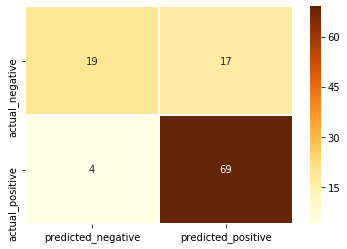

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rfc = RandomForestClassifier(n_jobs=-1)

rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                                train_features=cv_sw_train_features, train_labels=class_train,
                                                test_features=cv_sw_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'], color = 0) # heatmap - tons vermelho com stop word

#### 6.2 RF sem stop words

Model Performance metrics:
------------------------------
Accuracy: 0.6972
Precision: 0.6793
Recall: 0.6972
F1 Score: 0.6806

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.74      0.85      0.79        73
         neg       0.56      0.39      0.46        36

    accuracy                           0.70       109
   macro avg       0.65      0.62      0.62       109
weighted avg       0.68      0.70      0.68       109


Heat Map:
------------------------------
0.6972477064220184


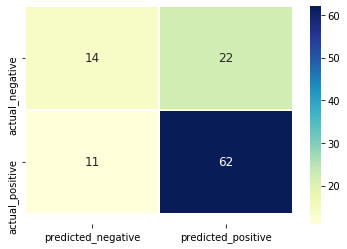

In [ ]:
rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                                train_features=cv_train_features, train_labels=class_train,
                                                test_features=cv_test_features, test_labels=class_test)

display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'],color = 1) # heatmap - mudança de cor para azul sem stop word

### 7. TF-IDF

O valor tf–idf, é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Ela é frequentemente utilizada como fator de ponderação na recuperação de informações e na mineração de dados.

O valor tf–idf de uma palavra aumenta proporcionalmente à medida que aumenta o número de ocorrências dela em um documento, no entanto, esse valor é equilibrado pela frequência da palavra no corpus. Isso auxilia a distinguir o fato da ocorrência de algumas palavras serem geralmente mais comuns que outras.

Shape das features de treino: (433, 13184)  Shape das features de teste: (109, 13184) 

Model Performance metrics:
------------------------------
Accuracy: 0.7798
Precision: 0.7834
Recall: 0.7798
F1 Score: 0.7592

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.78      0.95      0.85        73
         neg       0.80      0.44      0.57        36

    accuracy                           0.78       109
   macro avg       0.79      0.69      0.71       109
weighted avg       0.78      0.78      0.76       109


Heat Map:
------------------------------
0.7798165137614679


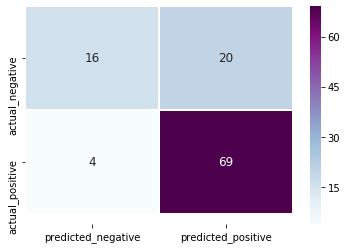

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer

tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_features.ravel())
tv_test_features = tv.transform(test_features.ravel())

print('Shape das features de treino:', tv_train_features.shape, ' Shape das features de teste:', tv_test_features.shape, '\n')

rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                               train_features=tv_train_features, train_labels=class_train,
                                               test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'],color = 2)

### 8. STEMMER

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
Model Performance metrics:
------------------------------
Accuracy: 0.7431
Precision: 0.7354
Recall: 0.7431
F1 Score: 0.7191

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.75      0.92      0.83        73
         neg       0.70      0.39      0.50        36

    accuracy                           0.74       109
   macro avg       0.73      0.65      0.66       109
weighted avg       0.74      0.74      0.72       109


Heat Map:
------------------------------
0.7431192660550459


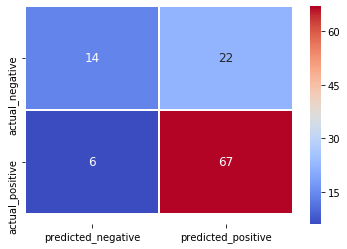

In [ ]:
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

X = data.drop('opinion', axis=1).values
y = data['opinion'].values

corpus = []
for review in data['reviews']:
    phrase = []
    for word in review.split():
        w_stemmed = stemmer.stem(word)
        phrase.append(w_stemmed)
    corpus.append(phrase)
# Separate data into train and test
train_features, test_features, class_train, class_test = train_test_split(corpus, y, test_size=0.20, random_state=10)

rfc_stem_predictions = train_predict_model(classifier=rfc, 
                                               train_features=tv_train_features, train_labels=class_train,
                                               test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_stem_predictions,classes=['pos', 'neg'],color = 3)

In [ ]:
data.head()

,opinion,reviews
0,neg,i wanted to love this i was even prepared for...
1,pos,grove square cappuccino cups were excellent t...
2,neg,i bought the grove square hazelnut cappuccino ...
3,neg,i love my keurig and i love most of the keuri...
4,neg,it s a powdered drink no filter in k cup br ...


### 9. Separação de palavras positivas e negativas

In [ ]:
# Palavras negativas, removendo stopwords

neg_phrases = data[data['opinion'] == 'neg']
neg_string = []
for phrase in neg_phrases['reviews']:
    for word in phrase.split():
        if word not in stopwords.words('portuguese'):
            neg_string.append(word)

neg_text = pd.Series(neg_string).str.cat(sep=' ')

In [ ]:
# Palavras positivas, removendo stopwords

pos_phrases = data[data['opinion'] == 'pos']
pos_string = []
for phrase in pos_phrases['reviews']:
    for word in phrase.split():
        if word not in stopwords.words('portuguese'):
            pos_string.append(word)

pos_text = pd.Series(pos_string).str.cat(sep=' ')

### 10. WordCloud

Word cloud de palavras negativas

In [ ]:
!pip install wordcloud

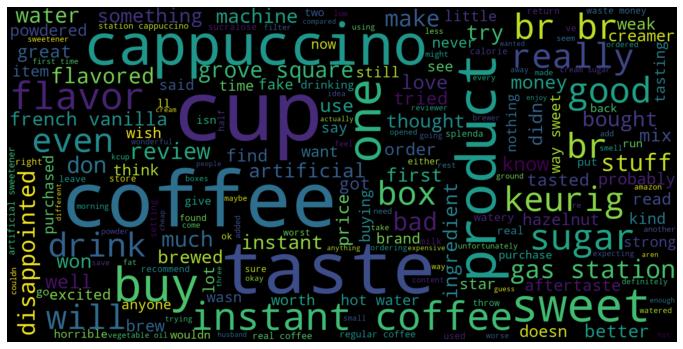

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud de palavras positivas

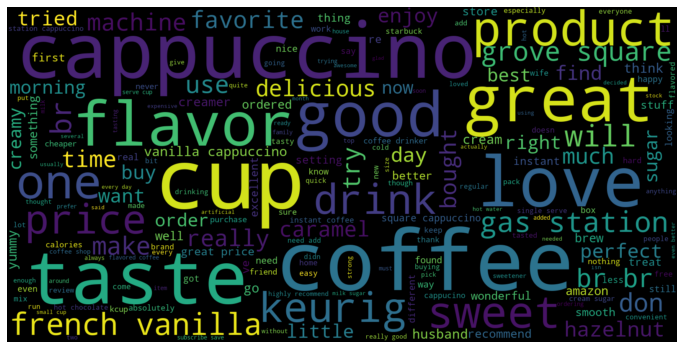

In [ ]:

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()